In [1]:
from utils import *

from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import lightgbm as lgb

%matplotlib inline
data_path = 'data/'
data_path = 'dataframes/'
seed=1204

submission_path=data_path+'submission/'
fold_path = 'fold_data/'


cv_loss_list=[]
n_iteration_list=[]
def score(params):
    print("Training with params: ")
    print(params)
    cv_losses=[]
    cv_iteration=[]
    for (train_idx,val_idx) in cv:
        cv_train = X.iloc[train_idx]
        cv_val = X.iloc[val_idx]
        cv_y_train = y[train_idx]
        cv_y_val = y[val_idx]
        lgb_model = lgb.train(params, lgb.Dataset(cv_train, label=cv_y_train), 2000, 
                          lgb.Dataset(cv_val, label=cv_y_val), verbose_eval=False, 
                          early_stopping_rounds=100, categorical_feature=(0,1,6))
       
        train_pred = lgb_model.predict(cv_train,lgb_model.best_iteration+1)
        val_pred = lgb_model.predict(cv_val,lgb_model.best_iteration+1)
        
        val_loss = root_mean_squared_error(cv_y_val,val_pred)
        train_loss = root_mean_squared_error(cv_y_train,train_pred)
        print('Train RMSE: {}. Val RMSE: {}'.format(train_loss,val_loss))
        print('Best iteration: {}'.format(lgb_model.best_iteration))
        cv_losses.append(val_loss)
        cv_iteration.append(lgb_model.best_iteration)
    print('6 fold results: {}'.format(cv_losses))
    cv_loss_list.append(cv_losses)
    n_iteration_list.append(cv_iteration)
    
    mean_cv_loss = np.mean(cv_losses)
    print('Average iterations: {}'.format(np.mean(cv_iteration)))
    print("Mean Cross Validation RMSE: {}\n".format(mean_cv_loss))
    return {'loss': mean_cv_loss, 'status': STATUS_OK}

def get_cv_idxs(df,start,end):
    result=[]
    for i in range(start,end+1):
        dates = df.date_block_num
        train_idx = np.array(df.loc[dates <i].index)
        val_idx = np.array(df.loc[dates == i].index)
        result.append((train_idx,val_idx))
    return np.array(result)

def optimize(space,seed=seed,max_evals=5):
    
    best = fmin(score, space, algo=tpe.suggest, 
        # trials=trials, 
        max_evals=max_evals)
    return best


In [2]:
import pandas as pd
import os
import numpy as np
import pickle
#os - operating system dependent. to read/write files
#pd - pandas for data analysis/modeling

data_path = 'data/'
dataframes_path = 'dataframes/'

#get DataFrames
all_data1 = pd.read_pickle(os.path.join(dataframes_path, 'saleswith12lags1.pickle'))
all_data2 = pd.read_pickle(os.path.join(dataframes_path, 'saleswith12lags2.pickle'))
all_data3 = pd.read_pickle(os.path.join(dataframes_path, 'saleswith12lags3.pickle'))

all_data=pd.concat([all_data1,all_data2,all_data3], ignore_index=True)
del all_data1,all_data2,all_data3
all_data = all_data.reset_index().drop('index',axis=1)

all_data.tail()

,shop_id,item_id,date_block_num,date,item_cnt_month,item_price,item_category_id,item_cat_block_target_sum,item_cat_block_target_mean,item_block_target_sum,...,item_block_target_sum_lag_12,item_block_target_mean_lag_12,shop_block_target_sum_lag_12,shop_block_target_mean_lag_12,item_cnt_month_lag_12,December,Newyear_Xmas,Valentine_MenDay,WomenDay,Easter_Labor
43861116,21,7635,33,2015-10-01,0,2100.0,64,64,0.155640,1,...,1,0.022720,1912,0.353271,0,False,False,False,False,False
43861117,21,7638,33,2015-10-01,0,1890.0,64,64,0.155640,1,...,1,0.022720,1912,0.353271,0,False,False,False,False,False
43861118,21,7640,33,2015-10-01,0,4040.0,64,64,0.155640,1,...,1,0.022720,1912,0.353271,0,False,False,False,False,False
43861119,21,7632,33,2015-10-01,0,2310.0,64,64,0.155640,1,...,1,0.022720,1912,0.353271,0,False,False,False,False,False
43861120,21,7440,33,2015-10-01,0,299.0,57,57,0.062683,1,...,2,0.045441,1912,0.353271,0,False,False,False,False,False


In [17]:
cat=['shop_id', 'item_id', 'item_category_id', 'December', 'Newyear_Xmas', 'Valentine_MenDay', 'WomenDay', 'Easter_Labor']

In [18]:
catcols=[all_data.columns.get_loc(c) for c in all_data.columns if c in cat]
catcols

[0, 1, 6, 48, 49, 50, 51, 52]

In [3]:
X = all_data.drop(['item_cnt_month','date'],axis=1)
y = all_data.item_cnt_month.values
X.drop('date_block_num',axis=1,inplace=True)
cv = get_cv_idxs(all_data,28,33)

In [2]:
#all_data = get_all_data(data_path,'new_sales_lag_after12.pickle')

#X,y = get_X_y(all_data,33)
#X.drop('date_block_num',axis=1,inplace=True)
#cv = get_cv_idxs(all_data,28,33)

In [ ]:
del all_data
space = {
#     'max_depth': hp.choice('max_depth', np.arange(3, 15, dtype=int)),
    'subsample': hp.quniform('subsample', 0.5, 1, 0.05),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.05),
    'min_data_in_leaf': hp.choice('min_data_in_leaf',np.arange(5, 30,1, dtype=int)),
    'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
    'seed':seed,
    'objective': 'regression',
    'metric':'rmse',
    'boosting':'gdbt',
    'task':'train'
}
best_hyperparams = optimize(space,max_evals=5)
print("The best hyperparameters are: ")
print(best_hyperparams)



Training with params: 
{'boosting': 'gdbt', 'colsample_bytree': 0.55, 'learning_rate': 0.45, 'metric': 'rmse', 'min_data_in_leaf': 21, 'objective': 'regression', 'seed': 1204, 'subsample': 0.55, 'task': 'train'}


/Users/vishwa/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [0, 1, 6]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))


In [4]:
all_data = get_all_data(data_path,'new_sales_lag_after12.pickle')

X,y = get_X_y(all_data,33)
X.drop('date_block_num',axis=1,inplace=True)

cv = get_cv_idxs(all_data,28,33)

In [5]:
lgb_params = {
               'colsample_bytree': 0.8,
               'metric': 'rmse',
               'min_data_in_leaf': 21, 
               'subsample': 0.55, 
               'learning_rate': 0.225, 
               'objective': 'regression', 
               'bagging_seed': 128, 
               'num_leaves': 128,
               'bagging_freq':1,
               'seed':1204
              }

In [6]:
lgb_model_full = lgb.train(lgb_params, lgb.Dataset(X, label=y), 708, 
                      lgb.Dataset(X, label=y), verbose_eval=10)

[10]	valid_0's rmse: 2.20369
[20]	valid_0's rmse: 2.04988
[30]	valid_0's rmse: 1.98889
[40]	valid_0's rmse: 1.93211
[50]	valid_0's rmse: 1.89621
[60]	valid_0's rmse: 1.86918
[70]	valid_0's rmse: 1.84547
[80]	valid_0's rmse: 1.8276
[90]	valid_0's rmse: 1.80814
[100]	valid_0's rmse: 1.79248
[110]	valid_0's rmse: 1.77737
[120]	valid_0's rmse: 1.76527
[130]	valid_0's rmse: 1.75302
[140]	valid_0's rmse: 1.74165
[150]	valid_0's rmse: 1.73041
[160]	valid_0's rmse: 1.72031
[170]	valid_0's rmse: 1.70966
[180]	valid_0's rmse: 1.70209
[190]	valid_0's rmse: 1.69364
[200]	valid_0's rmse: 1.68329
[210]	valid_0's rmse: 1.67472
[220]	valid_0's rmse: 1.66513
[230]	valid_0's rmse: 1.65829
[240]	valid_0's rmse: 1.64898
[250]	valid_0's rmse: 1.63801
[260]	valid_0's rmse: 1.63096
[270]	valid_0's rmse: 1.62359
[280]	valid_0's rmse: 1.61482
[290]	valid_0's rmse: 1.6068
[300]	valid_0's rmse: 1.60125
[310]	valid_0's rmse: 1.5948
[320]	valid_0's rmse: 1.58852
[330]	valid_0's rmse: 1.58173
[340]	valid_0's rmse: 

In [11]:
import os
test = pd.read_csv(os.path.join(data_path, 'x_test_data.csv'))
test.drop(['date_block_num'],axis=1,inplace=True)
test_pred = lgb_model_full.predict(test,708)

In [16]:
#item_cnt_month = np.clip(item_cnt_month,0,clip)
test= pd.read_csv(os.path.join(data_path, 'test.csv.gz'))
sub = test.copy()
sub['item_cnt_month'] = test_pred
sub.drop(['item_id','shop_id'],axis=1,inplace=True)
sub.to_csv('submissions/' + "lightgbm"+'.csv',index=False)

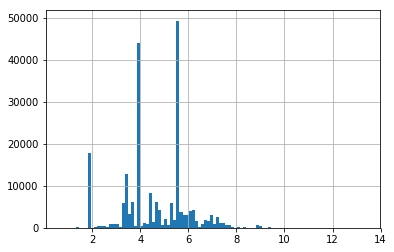

In [17]:
pd.Series(test_pred).hist(bins=100)